In [1]:
import numpy as np
import pandas as pd
import model_set
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
import pickle
import model_set
from train_predict import train_se,predict_se,train_predict_rank

In [36]:
CSI_RSRP_COLUMNS = ['PCell1 -Beam CSI-RSRP','PCell2 -Beam CSI-RSRP','PCell3 -Beam CSI-RSRP',
                    'PCell4 -Beam CSI-RSRP','PCell5 -Beam CSI-RSRP','PCell6 -Beam CSI-RSRP','PCell7 -Beam CSI-RSRP','PCell8 -Beam CSI-RSRP']
CSI_RSRQ_COLUMNS = ['PCell1 -Beam CSI-RSRQ','PCell2 -Beam CSI-RSRQ','PCell3 -Beam CSI-RSRQ',
                    'PCell4 -Beam CSI-RSRQ','PCell5 -Beam CSI-RSRQ','PCell6 -Beam CSI-RSRQ','PCell7 -Beam CSI-RSRQ','PCell8 -Beam CSI-RSRQ']
CSI_SINR_COLUMNS = ['PCell1 -Beam CSI-SINR','PCell2 -Beam CSI-SINR','PCell3 -Beam CSI-SINR',
                    'PCell4 -Beam CSI-SINR','PCell5 -Beam CSI-SINR','PCell6 -Beam CSI-SINR','PCell7 -Beam CSI-SINR','PCell8 -Beam CSI-SINR']
CSI_INDEX_COLUMNS = ['PCell1 -Beam CSI-Index','PCell2 -Beam CSI-Index','PCell3 -Beam CSI-Index',
                    'PCell4 -Beam CSI-Index','PCell5 -Beam CSI-Index','PCell6 -Beam CSI-Index','PCell7 -Beam CSI-Index','PCell8 -Beam CSI-Index']
SS_SINR_COLUMNS = ['SSB Index0 SINR','SSB Index1 SINR','SSB Index2 SINR','SSB Index3 SINR','SSB Index4 SINR','SSB Index5 SINR','SSB Index6 SINR']
SS_RSRP_COLUMNS = ['SSB Index0 RSRP','SSB Index1 RSRP','SSB Index2 RSRP','SSB Index3 RSRP','SSB Index4 RSRP','SSB Index5 RSRP','SSB Index6 RSRP']
CSI_SERVING_COL = ['PCell1 -Beam Serving Beam','PCell2 -Beam Serving Beam','PCell3 -Beam Serving Beam','PCell4 -Beam Serving Beam','PCell5 -Beam Serving Beam',
                   'PCell6 -Beam Serving Beam','PCell7 -Beam Serving Beam','PCell8 -Beam Serving Beam']
CSI_RSRP_IDX_COLUNMS = ['CSI-RSRP-Index0', 'CSI-RSRP-Index1', 'CSI-RSRP-Index2', 'CSI-RSRP-Index3', 'CSI-RSRP-Index4', 'CSI-RSRP-Index5','CSI-RSRP-Index6', 'CSI-RSRP-Index7',
                        'CSI-RSRP-Index8', 'CSI-RSRP-Index9', 'CSI-RSRP-Index10', 'CSI-RSRP-Index11', 'CSI-RSRP-Index12','CSI-RSRP-Index13', 'CSI-RSRP-Index14', 'CSI-RSRP-Index15',
                        'CSI-RSRP-Index16', 'CSI-RSRP-Index17', 'CSI-RSRP-Index18', 'CSI-RSRP-Index19','CSI-RSRP-Index20', 'CSI-RSRP-Index21', 'CSI-RSRP-Index22', 'CSI-RSRP-Index23',
                        'CSI-RSRP-Index24', 'CSI-RSRP-Index25', 'CSI-RSRP-Index26', 'CSI-RSRP-Index27', 'CSI-RSRP-Index28', 'CSI-RSRP-Index29', 'CSI-RSRP-Index30', 'CSI-RSRP-Index31']
CSI_SINR_IDX_COLUNMS = ['CSI-SINR-Index0', 'CSI-SINR-Index1', 'CSI-SINR-Index2', 'CSI-SINR-Index3', 'CSI-SINR-Index4', 'CSI-SINR-Index5','CSI-SINR-Index6', 'CSI-SINR-Index7',
                        'CSI-SINR-Index8', 'CSI-SINR-Index9', 'CSI-SINR-Index10', 'CSI-SINR-Index11', 'CSI-SINR-Index12','CSI-SINR-Index13', 'CSI-SINR-Index14', 'CSI-SINR-Index15',
                        'CSI-SINR-Index16', 'CSI-SINR-Index17', 'CSI-SINR-Index18', 'CSI-SINR-Index19','CSI-SINR-Index20', 'CSI-SINR-Index21', 'CSI-SINR-Index22', 'CSI-SINR-Index23',
                        'CSI-SINR-Index24', 'CSI-SINR-Index25', 'CSI-SINR-Index26', 'CSI-SINR-Index27', 'CSI-SINR-Index28', 'CSI-SINR-Index29', 'CSI-SINR-Index30', 'CSI-SINR-Index31']
PERFORMANCE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s','NR PRB Num DL/slot','NR RI','NR Avg Rank DL/s',
                       'NR DL Total NACK/s','NR DL Total ACK/s','NR PDSCH Initial BLER','NR PDSCH BLER','NR DL Avg MCS'] 
ALL_COLUMNS = CSI_RSRP_COLUMNS+CSI_RSRQ_COLUMNS+CSI_SINR_COLUMNS+CSI_INDEX_COLUMNS+SS_SINR_COLUMNS+SS_RSRP_COLUMNS+PERFORMANCE_COLUMNS
# 归一化参数
RSRP_MAX = -40
RSRP_MIN = -125
RSRQ_MAX = -4
RSRQ_MIN = -30
SE_MAX = 4000
RI_MAX = 4
MCS_MAX = 27
SINR_MAX = 50
SINR_MIN = -20
RI_COLUMN = ['NR Avg Rank DL/s']
MCS_COLUMN = ['NR DL Avg MCS']
BLER_COLUMN = ['NR PDSCH BLER']
SEVING_IDX = ['Serving idx']
LOC_COLUMNS = ['Longitude','Latitude']
SE_COLUMNS = ['NR MAC Throughput DL','NR PRB Num DL/s']
train_features = CSI_RSRP_IDX_COLUNMS+SS_RSRP_COLUMNS

In [31]:
with open('dataset_514/0415/data_834_linear_by_idx_loc.pkl','rb') as f:
    data_set_834_415 = pickle.load(f)
with open('dataset_514/0418/data_834_linear_by_idx_loc.pkl','rb') as f:
    data_set_834_418 = pickle.load(f)
with open('dataset_514/0420/data_834_linear_by_idx_loc.pkl','rb') as f:
    data_set_834_420 = pickle.load(f)
with open('dataset_514/0426/data_834_linear_by_idx_loc.pkl','rb') as f:
    data_set_834_426 = pickle.load(f)
with open('dataset_514/0412/data_900_linear_by_idx_loc.pkl','rb') as f:
    data_set_900_412 = pickle.load(f)   

# with open('dataset_503/data_834_linear_by_idx_415.pkl','rb') as f:
#     data_set_834_415 = pickle.load(f)
# with open('dataset_503/data_900_linear_by_idx_412.pkl','rb') as f:
#     data_set_900_412 = pickle.load(f)
# with open('dataset_503/data_834_linear_by_idx_418.pkl','rb') as f:
#     data_set_834_418 = pickle.load(f)
# with open('dataset_503/data_834_linear_by_idx_420.pkl','rb') as f:
#     data_set_834_420 = pickle.load(f)
# with open('dataset_503/data_834_linear_by_idx_426.pkl','rb') as f:
#     data_set_834_426 = pickle.load(f)

data_set_834 = pd.concat((data_set_834_415,data_set_834_418,data_set_834_420,data_set_834_426))
LANGITUDE = [114,115]
LATITUDE = [22,23]
data_set_834[LOC_COLUMNS[0]] = (data_set_834[LOC_COLUMNS[0]] - LANGITUDE[0])/(LANGITUDE[1]-LANGITUDE[0])
data_set_834[LOC_COLUMNS[1]] = (data_set_834[LOC_COLUMNS[1]] - LATITUDE[0])/(LATITUDE[1]-LATITUDE[0])
data_set_900_412[LOC_COLUMNS[0]] = (data_set_900_412[LOC_COLUMNS[0]] - LANGITUDE[0])/(LANGITUDE[1]-LANGITUDE[0])
data_set_900_412[LOC_COLUMNS[1]] = (data_set_900_412[LOC_COLUMNS[1]] - LATITUDE[0])/(LATITUDE[1]-LATITUDE[0])

In [27]:
# df = data_set_834.sort_values(['Longitude', 'Latitude'])

# # 划分数据为训练集和测试集
# train_ratio = 0.8
# train = pd.DataFrame(columns=df.columns)
# test = pd.DataFrame(columns=df.columns)
# train_lats = []  # 存储训练集中已有的纬度
# train_lons = []  # 存储训练集中已有的经度
# for i, row in df.iterrows():
#     record = pd.DataFrame(row).transpose()
#     if len(train) / len(df) < train_ratio:
#         # 分配到训练集中
#         train = pd.concat([train, record], axis=0)
#         train_lats.append(row['Latitude'])
#         train_lons.append(row['Longitude'])
#     else:
#         # 分配到测试集中
#         lat, lon = row['Latitude'], row['Longitude']
#         while lat in train_lats and lon in train_lons:
#             i += 1
#             lat, lon = df.loc[i, ['Latitude', 'Longitude']]
#         record['Latitude'] = lat
#         record['Longitude'] = lon
#         test = pd.concat([test, record], axis=0)

# print('Train size:', len(train))
# print('Test size:', len(test))

Train size: 26242
Test size: 6560


In [42]:
# df = data_set_900_412.sort_values(['Longitude', 'Latitude'])

# # 划分数据为训练集和测试集
# train_ratio = 0.8
# train = pd.DataFrame(columns=df.columns)
# test = pd.DataFrame(columns=df.columns)
# train_lats = []  # 存储训练集中已有的纬度
# train_lons = []  # 存储训练集中已有的经度
# for i, row in df.iterrows():
#     record = pd.DataFrame(row).transpose()
#     if len(train) / len(df) < train_ratio:
#         # 分配到训练集中
#         train = pd.concat([train, record], axis=0)
#         train_lats.append(row['Latitude'])
#         train_lons.append(row['Longitude'])
#     else:
#         # 分配到测试集中
#         lat, lon = row['Latitude'], row['Longitude']
#         while lat in train_lats and lon in train_lons:
#             i += 1
#             lat, lon = df.loc[i, ['Latitude', 'Longitude']]
#         record['Latitude'] = lat
#         record['Longitude'] = lon
#         test = pd.concat([test, record], axis=0)

# print('Train size:', len(train))
# print('Test size:', len(test))
# with open('dataset_503/data_900_train_test.pkl','wb') as f:
#     pickle.dump((train,test),f)

Train size: 4052
Test size: 1012


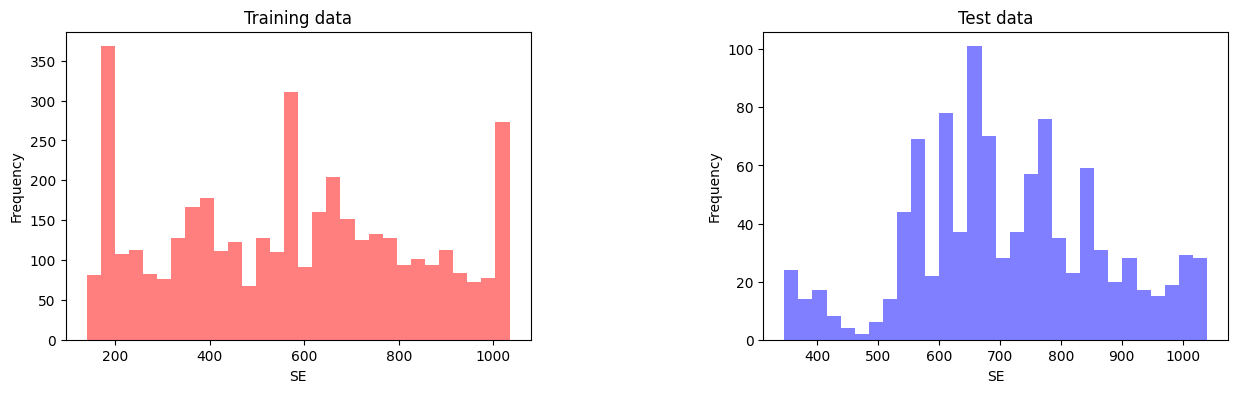

In [43]:
train,test = train_test_split(data_set_834,test_size=0.2,shuffle=True,random_state=1)
# train,test = train_test_split(data_set_900_412,test_size=0.2,shuffle=False)


train_x = train[train_features]
train_y = train['SE']

test_x = test[train_features]
test_y = test['SE']

# val_x = val[train_features]
# val_y = val['SE']


# 创建三个子图
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一个子图
axs[0].hist(train['NR MAC Throughput DL'], bins=30, alpha=0.5, color='r')
axs[0].set_xlabel('SE')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Training data')

# # # 绘制第二个子图
# # axs[1].hist(val_y, bins=30, alpha=0.5, color='g')
# # axs[1].set_xlabel('SE')
# # axs[1].set_ylabel('Frequency')
# # axs[1].set_title('Validation data')

# 绘制第三个子图
axs[1].hist(test['NR MAC Throughput DL'], bins=30, alpha=0.5, color='b')
axs[1].set_xlabel('SE')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Test data')

# 调整子图之间的距离
plt.subplots_adjust(wspace=0.5)

# 显示图像
plt.show()


In [45]:


train_x = train_x[train_features].to_numpy()
test_x = test_x[train_features].to_numpy()
# val_x = val_x[train_features].to_numpy()
# val_y = val_y.to_numpy()
train_y = train_y.to_numpy()
test_y = test_y.to_numpy()

In [46]:
# r_seed = 67
# 78
# np.random.seed(r_seed)
# tf.random.set_seed(r_seed)
model = model_set.mlp(train_x.shape[1])
_ = model.fit(x=train_x, y=train_y, epochs=100, batch_size=64)
# model = train_se(100,train_x,train_y,test_x,test_y,patience= 15,predict_mode=model_set.mlp)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 32)                1344      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 33        
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/100
64/64 [==============================] - 0s 714us/step - loss: 50.7944
Epoch 2/100
64/64 [==============================] - 0s 657us/step - loss: 21.8339
Epoch 3/100
64/64 [==============================] - 0s 649us/step -

In [48]:
# # 保存模型
# model.save('mlp_model_834_1')
model.save('mlp_model_900_1')
print('Model saved to disk.')

INFO:tensorflow:Assets written to: mlp_model_900_1\assets
Model saved to disk.


In [47]:
# 从文件中加载模型
new_model = tf.keras.models.load_model('mlp_model_834_1')
# print('Model loaded from disk.')
mlp_est_y = model.predict(test_x).flatten()
print('mse:')
print("mlp:", np.mean((mlp_est_y-test_y)**2))
print('max error:')
print("mlp:",np.max((mlp_est_y-test_y)**2))
print('mape:')
print("mlp:",np.mean(np.abs((mlp_est_y-test_y)/test_y)))
print('sdape:')
print("mlp:",np.std(np.abs((mlp_est_y-test_y)/test_y)))

mse:
mlp: 0.012088568184406548
max error:
mlp: 0.13578941469349887
mape:
mlp: 0.15061342648507262
sdape:
mlp: 0.12164293207698984
